In [1]:
import boto3
from datetime import datetime, timedelta

client = boto3.client('xray')

In [2]:
# Function names
LAMBDA_LLRT = "LambdaColdstartStack-LambdaColdStartLlrt496D79BC-0YKYMNczUDV3"
LAMBDA_RUST = "LambdaColdstartStack-LambdaColdStartRustCB5A94EE-ILs7bF4xgdRP"
LAMBDA_NODEJS = "LambdaColdstartStack-LambdaColdStartPython1AA49A8F-WX0q25mQnFqU"
LAMBDA_PYTHON = "LambdaColdstartStack-LambdaColdStartTypescriptB243-9Y1lGunA3vAe"

In [3]:
# Function url
LAMBDA_LLRT_URL = "https://2uydoev4lf6htqoi2f3waou6re0tejaw.lambda-url.ap-northeast-1.on.aws/"
LAMBDA_RUST_URL = "https://7rq7ulqjc67ucb74mqc3t7i2zu0hsrjo.lambda-url.ap-northeast-1.on.aws/"
LAMBDA_NODEJS_URL = "https://ajn2p4pppjdm5d7ijh666gijcm0zofoy.lambda-url.ap-northeast-1.on.aws/"
LAMBDA_PYTHON_URL = "https://zhusyi3wldjhtn6sulhtspafwi0jehss.lambda-url.ap-northeast-1.on.aws/"

### 50 requests per url

In [ ]:
import requests
urls = [LAMBDA_LLRT_URL, LAMBDA_RUST_URL, LAMBDA_NODEJS_URL, LAMBDA_PYTHON_URL]
for url in urls:  
    print(f"processing url: {url}")
    for x in range(0, 50):
        requests.get(url, verify=False)


### get trace summaries

In [7]:
def get_trace_summaries(name: str) -> list[object]:   
    paginator = client.get_paginator('get_trace_summaries')
    response_iterator = paginator.paginate(
        # StartTime=(datetime.now() - timedelta(hours=3)).timestamp(),
        # EndTime=datetime.now().timestamp(),
        StartTime=datetime(2024, 4, 23, 12).timestamp(),
        EndTime=datetime(2024, 4, 23, 18).timestamp(),
        TimeRangeType='Service',
        Sampling=False,
        FilterExpression=f'service(id(name:"{name}"))'
    )
    result = response_iterator.build_full_result()
    trace_summary = result['TraceSummaries']
    return trace_summary


In [8]:
llrt_summaries = get_trace_summaries(LAMBDA_LLRT)
rust_summaries = get_trace_summaries(LAMBDA_RUST)
nodejs_summaries = get_trace_summaries(LAMBDA_NODEJS)
python_summaries = get_trace_summaries(LAMBDA_PYTHON)

### Duration and response average time

Duration: The length of time in seconds between the start time of the root segment and the end time of the last segment that completed.

Response: The length of time in seconds between the start and end times of the root segment. If the service performs work asynchronously, the response time measures the time before the response is sent to the user, while the duration measures the amount of time before the last traced activity completes.


In [9]:
def Average(lst: list[float]): 
    return sum(lst) / len(lst) 

In [10]:
llrt_duration_average = Average([summary['Duration'] for summary in llrt_summaries])
llrt_response_average = Average([summary['ResponseTime'] for summary in llrt_summaries])
print(f"llrt_duration_average: {llrt_duration_average}")
print(f"llrt_response_average: {llrt_response_average}")

llrt_duration_average: 0.04327480916030535
llrt_response_average: 0.03219847328244275


In [11]:
rust_duration_average = Average([summary['Duration'] for summary in rust_summaries])
rust_response_average = Average([summary['ResponseTime'] for summary in rust_summaries])
print(f"rust_duration_average: {rust_duration_average}")
print(f"rust_response_average: {rust_response_average}")

rust_duration_average: 0.032391752577319584
rust_response_average: 0.031711340206185566


In [12]:
node_duration_average = Average([summary['Duration'] for summary in nodejs_summaries])
node_response_average = Average([summary['ResponseTime'] for summary in nodejs_summaries])
print(f"node_duration_average: {node_duration_average}")
print(f"node_response_average: {node_response_average}")

node_duration_average: 0.07464044943820225
node_response_average: 0.06282022471910112


In [13]:
python_duration_average = Average([summary['Duration'] for summary in python_summaries])
python_response_average = Average([summary['ResponseTime'] for summary in python_summaries])
print(f"python_duration_average: {python_duration_average}")
print(f"python_response_average: {python_response_average}")

python_duration_average: 0.08145263157894737
python_response_average: 0.06903157894736842


### Time Breakdown

- initialization time: Cold start time
- invocation time
- overhead time

In [15]:
import json

def get_time_breakdown(ids: list[str]) -> object:   
    initialization_time_total = 0
    initialization_count = 0
    invocation_time_total = 0
    invocation_count = 0

    overhead_time_total = 0
    overhead_count = 0

    for id in ids:
        response = client.batch_get_traces(
            TraceIds=[
                id
            ]
        )
        segments = response['Traces'][0]['Segments']
        for segment in segments: 
            document = segment['Document']
            json_doc = json.loads(document)
            if "subsegments" in json_doc:
                sub_segments = json_doc['subsegments']
                for sub_segment in sub_segments:
                    start = sub_segment['start_time']
                    end = sub_segment['end_time']
                    dur = end - start
                    if (sub_segment['name'] == "Initialization"):
                        initialization_count = initialization_count + 1
                        initialization_time_total = initialization_time_total + dur
                    elif (sub_segment['name'] == "Overhead"):
                        overhead_count = overhead_count + 1
                        overhead_time_total = overhead_time_total + dur
                    elif (sub_segment['name'] == "Invocation"):
                        invocation_count = invocation_count + 1
                        invocation_time_total = invocation_time_total + dur
                    
    return {
        "initialization_time_total": initialization_time_total,
        "initialization_count": initialization_count,
        "invocation_time_total": invocation_time_total,
        "invocation_count": invocation_count,
        "overhead_time_total": overhead_time_total,
        "overhead_count": overhead_count
    }


In [16]:
llrt_ids = [summary['Id'] for summary in llrt_summaries]
llrt_time_breakdown = get_time_breakdown(llrt_ids)
print("llrt_time_breakdown")
llrt_time_breakdown

llrt_time_breakdown


{'initialization_time_total': 0.47177958488464355,
 'initialization_count': 5,
 'invocation_time_total': 1.669888973236084,
 'invocation_count': 131,
 'overhead_time_total': 0.24699139595031738,
 'overhead_count': 131}

In [18]:
llrt_initialization_average = llrt_time_breakdown['initialization_time_total'] / llrt_time_breakdown['initialization_count']
llrt_invocation_average = llrt_time_breakdown['invocation_time_total'] / llrt_time_breakdown['invocation_count']
llrt_overhead_average = llrt_time_breakdown['overhead_time_total'] / llrt_time_breakdown['overhead_count']
print(f"llrt_initialization_average: {llrt_initialization_average}")
print(f"llrt_invocation_average: {llrt_invocation_average}")
print(f"llrt_overhead_average: {llrt_overhead_average}")

llrt_initialization_average: 0.09435591697692872
llrt_invocation_average: 0.012747244070504458
llrt_overhead_average: 0.0018854305034375373


In [19]:
rust_ids = [summary['Id'] for summary in rust_summaries]
rust_time_breakdown = get_time_breakdown(rust_ids)
print("rust_time_breakdown")
rust_time_breakdown

rust_time_breakdown


{'initialization_time_total': 0.24192500114440918,
 'initialization_count': 3,
 'invocation_time_total': 1.2693450450897217,
 'invocation_count': 97,
 'overhead_time_total': 0.08696269989013672,
 'overhead_count': 97}

In [20]:
rust_initialization_average = rust_time_breakdown['initialization_time_total'] / rust_time_breakdown['initialization_count']
rust_invocation_average = rust_time_breakdown['invocation_time_total'] / rust_time_breakdown['invocation_count']
rust_overhead_average = rust_time_breakdown['overhead_time_total'] / rust_time_breakdown['overhead_count']
print(f"rust_initialization_average: {rust_initialization_average}")
print(f"rust_invocation_average: {rust_invocation_average}")
print(f"rust_overhead_average: {rust_overhead_average}")

rust_initialization_average: 0.0806416670481364
rust_invocation_average: 0.013086031392677543
rust_overhead_average: 0.00089652267927976


In [21]:
node_ids = [summary['Id'] for summary in nodejs_summaries]
node_time_breakdown = get_time_breakdown(node_ids)
print("node_time_breakdown")
node_time_breakdown

node_time_breakdown


{'initialization_time_total': 1.358640193939209,
 'initialization_count': 3,
 'invocation_time_total': 3.1893770694732666,
 'invocation_count': 89,
 'overhead_time_total': 0.6624557971954346,
 'overhead_count': 89}

In [23]:
node_initialization_average = node_time_breakdown['initialization_time_total'] / node_time_breakdown['initialization_count']
node_invocation_average = node_time_breakdown['invocation_time_total'] / node_time_breakdown['invocation_count']
node_overhead_average = node_time_breakdown['overhead_time_total'] / node_time_breakdown['overhead_count']
print(f"node_initialization_average: {node_initialization_average}")
print(f"node_invocation_average: {node_invocation_average}")
print(f"node_overhead_average: {node_overhead_average}")

node_initialization_average: 0.452880064646403
node_invocation_average: 0.03583569740981198
node_overhead_average: 0.007443323563993647


In [24]:
python_ids = [summary['Id'] for summary in python_summaries]
python_time_breakdown = get_time_breakdown(python_ids)
print("python_time_breakdown")
python_time_breakdown

python_time_breakdown


{'initialization_time_total': 0.8679437637329102,
 'initialization_count': 3,
 'invocation_time_total': 4.251104831695557,
 'invocation_count': 95,
 'overhead_time_total': 0.816422700881958,
 'overhead_count': 95}

In [25]:
python_initialization_average = python_time_breakdown['initialization_time_total'] / python_time_breakdown['initialization_count']
python_invocation_average = python_time_breakdown['invocation_time_total'] / python_time_breakdown['invocation_count']
python_overhead_average = python_time_breakdown['overhead_time_total'] / python_time_breakdown['overhead_count']
print(f"python_initialization_average: {python_initialization_average}")
print(f"python_invocation_average: {node_invocation_average}")
print(f"python_overhead_average: {python_overhead_average}")

python_initialization_average: 0.28931458791097003
python_invocation_average: 0.03583569740981198
python_overhead_average: 0.008593923167178505


### Comparison by Plot

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 8})


In [27]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], "{:.2f}ms".format(y[i]), ha = 'center')

#### Duration

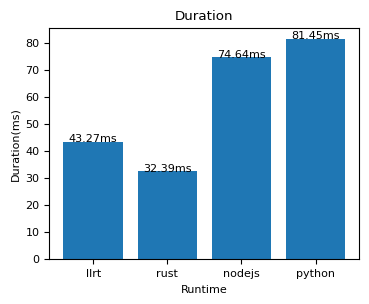

In [28]:
# duration comparison
x = np.array(["llrt", "rust", "nodejs", "python"])
y = np.array([llrt_duration_average, rust_duration_average, node_duration_average, python_duration_average])*1000

plt.figure(figsize=(4,3))
addlabels(x, y)
plt.title("Duration")
plt.xlabel("Runtime")
plt.ylabel("Duration(ms)")
plt.bar(x,y)
plt.show()


#### Response Time

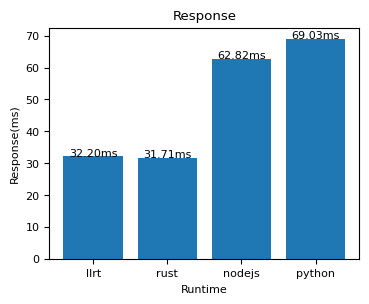

In [29]:
# Response comparison
x = np.array(["llrt", "rust", "nodejs", "python"])
y = np.array([llrt_response_average, rust_response_average, node_response_average, python_response_average])*1000

plt.figure(figsize=(4,3))
addlabels(x, y)
plt.title("Response")
plt.xlabel("Runtime")
plt.ylabel("Response(ms)")
plt.bar(x,y)
plt.show()

#### Initialization Time

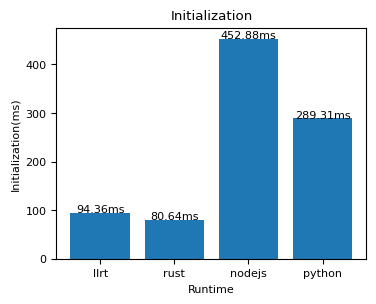

In [30]:
# initialization comparison
x = np.array(["llrt", "rust", "nodejs", "python"])
y = np.array([llrt_initialization_average, rust_initialization_average, node_initialization_average, python_initialization_average])*1000

plt.figure(figsize=(4,3))
addlabels(x, y)
plt.title("Initialization")
plt.xlabel("Runtime")
plt.ylabel("Initialization(ms)")
plt.bar(x,y)
plt.show()

#### Invocation time

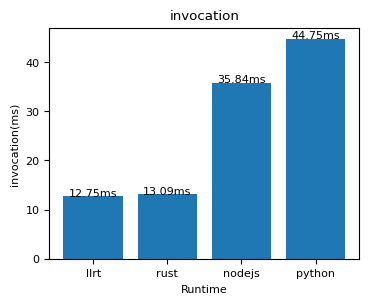

In [31]:
# invocation comparison
x = np.array(["llrt", "rust", "nodejs", "python"])
y = np.array([llrt_invocation_average, rust_invocation_average, node_invocation_average, python_invocation_average])*1000

plt.figure(figsize=(4,3))
addlabels(x, y)
plt.title("invocation")
plt.xlabel("Runtime")
plt.ylabel("invocation(ms)")
plt.bar(x,y)
plt.show()

#### Overhead time

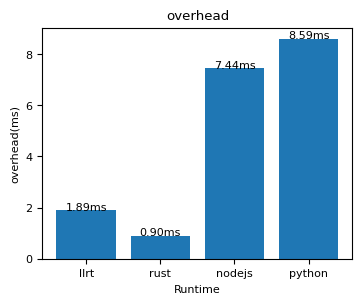

In [32]:
# overhead comparison
x = np.array(["llrt", "rust", "nodejs", "python"])
y = np.array([llrt_overhead_average, rust_overhead_average, node_overhead_average, python_overhead_average])*1000

plt.figure(figsize=(4,3))
addlabels(x, y)
plt.title("overhead")
plt.xlabel("Runtime")
plt.ylabel("overhead(ms)")
plt.bar(x,y)
plt.show()